In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 10})
import cvxpy as cp
import sklearn

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
import lcurve_functions as lc

from controlsair import AlgControls, AirProperties, load_cfg, sph2cart
from sources import Source
from receivers import Receiver
from field_free import FreeField
from decompositionclass import Decomposition

%matplotlib notebook

C:\Users\Cliente\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Teoria

Consideremos o campo sonoro em estado estacionário produzido por uma série de fontes de tom puro numa sala qualquer, com frequência $\omega$. Por campo em estado estacionário referimo-nos a um campo cujas propriedades estatísticas não variam com o tempo. A trasformada de Fourier de um fenômeno temporal em um dado ponto deste campo acústico é

\begin{equation}
p(\textbf{r}_m, t) \xrightarrow{\mathscr{F}} \tilde{p}(\textbf{r}_m, \text{j} \omega)
\end{equation}

Tal campo sonoro pode ser representado por uma combinação linear de **ondas planas**, cada uma viajando numa direção especificada pelo vetor do número de onda $\textbf{k} = (k_x, k_y, k_z)$. Cada onda plana pode ter uma amplitude e uma fase diferentes, dada por $P(\textbf{k})$. Assim, a amplitude complexa da pressão sonora medida no receptor $\textbf{r}_m = (x_m, y_m, z_m)$ é

\begin{equation}
\tilde{p}(\textbf{r}_m) = \iiint\limits_{-\infty}^{\infty} P(\textbf{k}) \text{e}^{-\text{j} \textbf{k} \cdot \textbf{r}_m}\text{d}\textbf{k} = \iiint\limits_{-\infty}^{\infty} P(\textbf{k}) \text{e}^{-\text{j}(k_x x_m + k_y y_m + k_z z_m)}\text{d}\textbf{k}
\end{equation}

Notemos que

\begin{equation}
\left\|\textbf{k}\right\|_{2}^{2} = \textbf{k} \cdot \textbf{k} = k_{x}^{2}+k_{y}^{2}+k_{z}^{2} = k_{0}^{2}
\end{equation}

Assim a norma $\ell_2$ do vetor $\textbf{k}$ é igual ao número de onda $k_0$ [rad/s], ao qual estamos mais acostumados. Também podemos notar que conhecendo $k_0$, teremos uma das componentes de $\textbf{k}$ dependente das outras duas. Por exemplo

\begin{equation}
k_{z} = \sqrt{k_{0}^{2}-(k_{x}^{2}+k_{y}^{2})} 
\end{equation}

Não há nada que impeça $k_{x}^{2}+k_{y}^{2} > k_{0}^{2}$, forçando o argumento da raíz para um número negativo e o valor da raiz quadrada para um número **complexo**. Isto resulta numa função exponencial decrescente em $z$ (uma **onda evanescente**). Vermos mais sobre isso depois. Por hora, vamos considerar apenas o caso em que $k_{x}^{2}+k_{y}^{2} \leq k_{0}^{2}$, forçando o argumento da raíz para um número $\geq 0$, o que resulta numa função exponencial oscilatória em todas as direções (uma **onda plana propagante**).

As equações vistas até aqui são uma **Transformada Espacial de Fourier**, o que implica que as operações são realizadas do domínio **espacial** contínuo para o domínio do **número de onda** também contínuo. Na prática vamos discretizar o problema. Uma forma de fazê-lo é considerar que a pressão sonora lida pelo microfone em $\textbf{r}_m$ é composta de uma **combinação linear de ondas planas propagantes**.

\begin{equation}
\tilde{p}(\textbf{r}_m) = \sum\limits_{i=1}^{L}\tilde{P}(\textbf{k}_i)\text{e}^{-\text{j}\textbf{k}_i \cdot \textbf{r}_m}
\end{equation}
em que as direcções de propagação das ondas planas estão uniformemente distribuídas por um domínio esférico; $\tilde{P}(\textbf{k}_i)$ é a amplitude complexa de cada onda plana. No limite $L \rightarrow \infty$, obtém-se a distribuição de pressão contínua dada acima.

Se coletarmos as amplitudes complexas das pressões medidas em um vetor $\textbf{p} = [\tilde{p}_1, \tilde{p}_2, \cdots, \tilde{p}_M]^T \ \in \mathbb{C}^{M \times 1}$, cada componente deste vetor pode ser expresso como no somatório acima, o que resulta numa equação matricial do tipo

\begin{equation}
\textbf{p} = \begin{bmatrix}
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_1} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_1} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_1}\\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_2} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_2} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_2}\\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_M} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_M} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_M}
\end{bmatrix}
\begin{bmatrix}
\tilde{P}(\textbf{k}_1) \\ \tilde{P}(\textbf{k}_2) \\ \vdots \\ \tilde{P}(\textbf{k}_L)
\end{bmatrix}
\end{equation}

Ou, de forma mais condensada

\begin{equation}
\textbf{p} = \textbf{H}\textbf{x} + \textbf{n}
\end{equation}
em que $\textbf{H} \ \in \mathbb{C}^{M \times L} $ é a nossa matriz do modelo, contendo kernels das $L$ ondas planas propagantes nos $M$ receptores, $\textbf{x} \ \in \mathbb{C}^{L \times 1}$ é o vetor solução (**desejado**), que contêm as amplitudes complexas de cada onda plana; $\textbf{n} \ \in \mathbb{C}^{M \times 1}$ é o ruído complexo associado às medições.

# Vamos criar um campo acústico simulado

Este campo acústico será composto da superposição de algumas ondas planas. 

$\textbf{OBS:}$ Estamos usando uma infra-estrutura construída pra pesquisar o problema e testar métodos inversos. Isto é muito útil por alguns motivos: (i) - lidar com problemas simulados (toy problems) dá uma boa ideia do que esperar obter num experimento; (ii) - o pipeline de pós-processamento é complexo e se você não tem um benchmark pode ser difícil apontar potenciais erros e problemas; (iii) - o teste com os problemas simulados é bem próximo da vida real com o experimento (em geral, depois de acertar os detalhes, basta medir as coisas e usar a infraestrutura construída. Finalmente, há uma série de funcionalidades úteis que construímos e que podemos usar pra ganhar insight sobre o problema.

## Primeiro, criamos alguns controles para as simulações.

In [2]:
air = AirProperties(temperature = 20)
controls = AlgControls(c0 = air.c0, freq_vec = [800, 1000, 1500, 2000])

## Arranjo de microfones 

As ondas planas presentes na cena simulada incidem em um arranjo de microfones. Vamos definir um arranjo e depois testar outras geometrias.

Uma coisa importante sobre os arranjos para este problema: 

- Se você quer medir propriedades tri-dimensionais em um campo acústico, seu arranjo também precisa ser tri-dimensional. Arranjos em linha ou puramente planos não vão funcionar bem. Isto porque um arranjo plano não tem como saber de que lado do plano vem uma frente de onda.

<IPython.core.display.Javascript object>


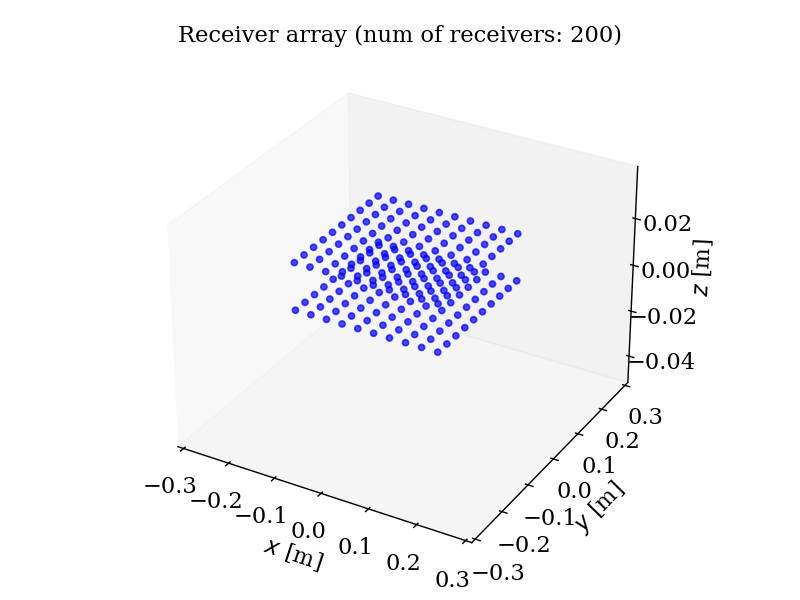

In [3]:
receivers = Receiver() # array object

### double layer planar array
receivers.double_planar_array(x_len = 0.3, n_x = 10, y_len = 0.3, n_y = 10, zr = 0, dz = 0.02)

### random 3D array 2
#receivers.random_3d_array2(x_len = 0.3, y_len = 0.3, z_len = 0.15, zr = -0.15/2,
#                      nx = 10, ny = 10, nz = 2, delta_xyz = None, seed = 0, plot = False)

### planar array - should fail
#receivers.planar_array(x_len = 0.3, n_x = 10, y_len = 0.3, n_y = 10, zr = 0)

### plot the array geometry
receivers.plot_array()

## Fontes sonoras

Vamos incluir dois monopolos na nossa cena. Eles estão a uma distâncai de $\pm 100$ m do arranjo - essencialmente são ondas planas incidentes.

In [4]:
distance = 1
s_coord1 = sph2cart(distance, np.pi/2-np.deg2rad(45), np.deg2rad(30))
s_coord2 = sph2cart(distance, np.pi/2-np.deg2rad(45), np.deg2rad(150))

# Source object
source = Source(coord = s_coord1) 
source.add_sources(coord = s_coord2)

print("Sources' coordinates are: {}".format(source.coord))

Sources' coordinates are: [[ 0.61237244  0.35355339  0.70710678]
 [-0.61237244  0.35355339  0.70710678]]


## Campo acústico

Vamos computar o campo acústico. Ele é o resultado da soma (**interferência**) entre as ondas causadas por cada um dos monopolos

In [5]:
field = FreeField(air, controls, receivers)
field.monopole_ff(sources = source)
field.pres_s[0] += field.pres_s[1]
pres_measured_noiseless = field.pres_s[0]

# adds random noise with given SNR
field.add_noise(snr = 30)
pres_measured_noise = field.pres_s[0]

print("Shape of measured field: {}".format(field.pres_s[0].shape))

Shape of measured field: (200, 4)


<IPython.core.display.Javascript object>


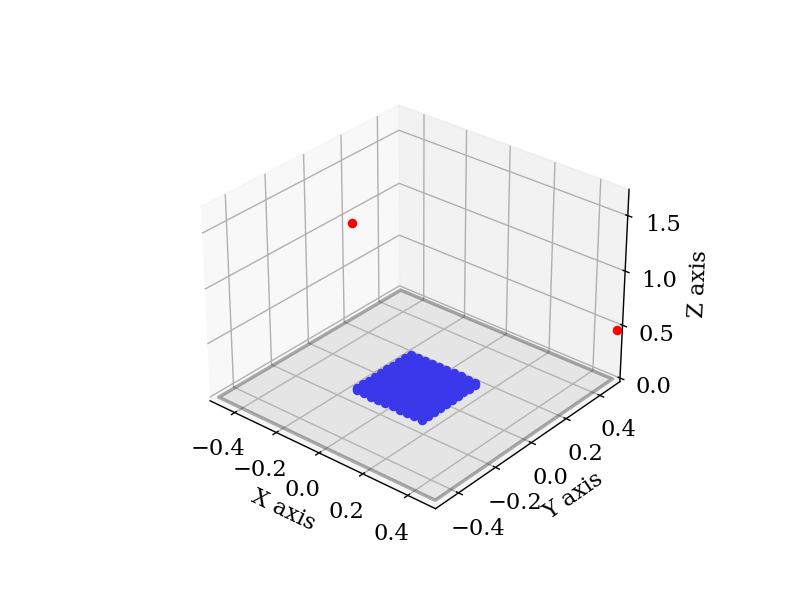

In [6]:
field.plot_scene(vsam_size=1)

<IPython.core.display.Javascript object>


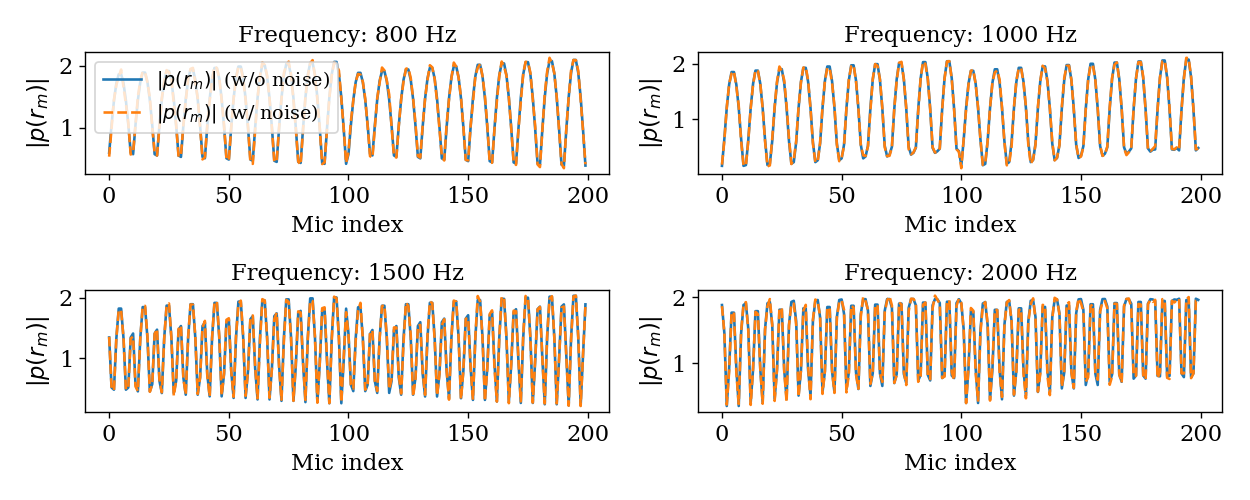

In [7]:
fig, axs = plt.subplots(2, 2, figsize = (10,4),)

f = 0
for row in np.arange(2):
    for col in np.arange(2):
        axs[row,col].plot(np.arange(receivers.coord.shape[0]) , np.abs(pres_measured_noiseless[:,f]), 
                          label = r'$|p(r_m)|$ (w/o noise)')
        axs[row,col].plot(np.arange(receivers.coord.shape[0]) , np.abs(pres_measured_noise[:,f]), '--',
                          label = r'$|p(r_m)|$ (w/ noise)')
        axs[row,col].set_title("Frequency: {:.0f} Hz".format(controls.freq[f]))
        axs[row,col].set_xlabel("Mic index")
        axs[row,col].set_ylabel(r"$|p(r_m)|$")
        f += 1
axs[0,0].legend(loc = 'upper left')
plt.tight_layout()

## Avaliando o que medimos

Note que a pressão sonora medida tem dimensão $M \times N_f$, em que $N_f$ é o número de frequências simuladas. 

In [8]:
print("Measured frequencies: {} Hz".format(controls.freq))
print("Shape of receiver array: {}".format(receivers.coord.shape))
print("Shape of measured sound field: {}".format(field.pres_s[0].shape))

Measured frequencies: [ 800 1000 1500 2000] Hz
Shape of receiver array: (200, 3)
Shape of measured sound field: (200, 4)


# Decomposição em ondas planas (Quais são os passos?)

1. Medir respostas ao impulso em $M$ coordenadas $\textbf{r}_1, \cdots, \textbf{r}_M$. Se a medição for realizada em uma sala, cada RIR vai conter: som direto, primeiras reflexões (vindas de direções esparsas) e a cauda reverberante (cujas direções de chegada são mais caóticas). Tais RIR's precisam ser transformadas para o domínio da frequência. Cada frequência comporá um vetor de dados medidos: $\textbf{p} = [\tilde{p}_1, \tilde{p}_2, \cdots, \tilde{p}_M]^T \ \in \mathbb{C}^{M \times 1}$ 

<nbsp>

2. Criar uma série de $L$ **direções possíveis** para as ondas planas. As direções são distribuídas numa esfera unitária, que será composta de $L$ ondas planas **propagantes**. O vetor unitário associado à direção de propagação será multiplicado por $k_0$, de forma que você tenha vetores número de onda  $\textbf{k}_1, \cdots, \textbf{k}_L$ e o raio de sua esfera de ondas planas seja $k_0$ [rad/m];
    
<nbsp>

3. Criar a matriz $M \times L$ do problema (Kernel - seu modelo de mundo):

\begin{equation}
\textbf{H} =
\begin{bmatrix}
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_1} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_1} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_1}\\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_2} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_2} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_2}\\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_M} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_M} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_M}
\end{bmatrix}
\end{equation}
    
<nbsp>

4. Computar o SVD da matriz $\textbf{H} = \textbf{U}\Sigma\textbf{V}^T$

<nbsp>
    
5. Usar o SVD e o vetor $\textbf{p}$ para computar um parâmetro de regularização, $\lambda$.
    
<nbsp> 
    
6. Computar a solução regularizada (as amplitudes complexas de suas $L$ ondas planas).

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

<nbsp>
    
7. Reconstrução e análise
    
\begin{equation}
\textbf{p}_{r} = \textbf{H}_{\text{r}} \ \hat{\textbf{x}}_{\lambda}
\end{equation}
    
\begin{equation}
\textbf{u}_{r} = -\frac{1}{\text{j}\omega \rho}\ \nabla\textbf{H}_{\text{r}} \ \hat{\textbf{x}}_{\lambda}
\end{equation}

# Montando o problema do zero (para uma frequência)
    
# 1. Os dados medidos
    
Nossa medição já está no formato necessário. Vamos apenas escolher uma frequência

In [9]:
index = 1
freq = controls.freq[index]
print(r'frequency = {0:.2f} Hz'.format(freq))
# Receptores
r_vecs = receivers.coord
print('shape da matriz de receptores: {}'.format(r_vecs.shape))
# Dados medidos (com algum ruído)
p = field.pres_s[0][:, index]
print('shape da matriz p: {}'.format(p.shape))

frequency = 1000.00 Hz
shape da matriz de receptores: (200, 3)
shape da matriz p: (200,)


# 2. Criar uma série de $L$ **direções possíveis**

Vamos usar a infraestrutura disponível. Isto porque precisamos de uma esfera que seja balanceada, o que implica que a distribuição de pontos na esfera precisa ser feita de modo que o ângulo sólido seja constante.

You choose L-curve to find optimal regularization parameter
The number of created waves is: 162


<IPython.core.display.Javascript object>


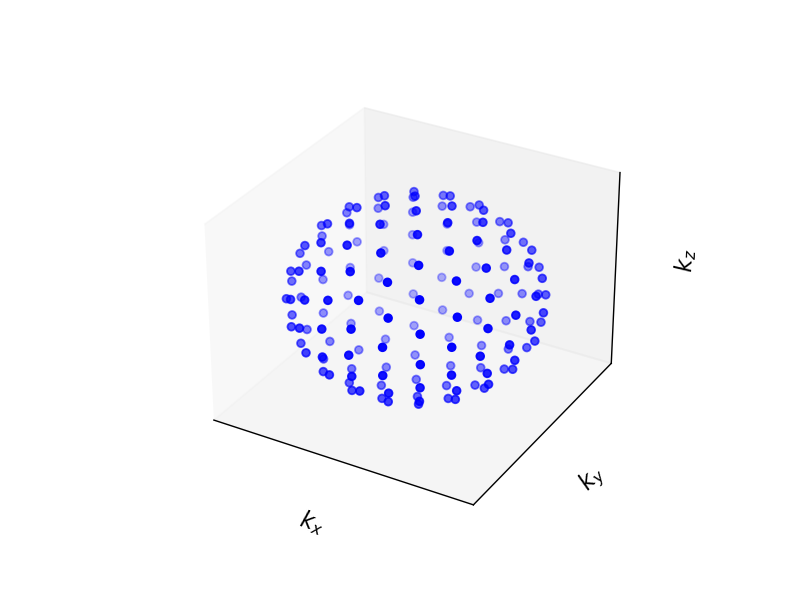

In [10]:
# Direções das ondas propagantes
ff_ded = Decomposition()
ff_ded.wavenum_dir(n_waves = 162, plot = True)
dirs = ff_ded.dir

Vamos checar um dos vetores unitários da esfera de possíveis direções. Lembre-se que ele deve ter norma unitária.

In [11]:
idk = 25
print("Unit vector: {}".format(dirs[idk,:]))
print("Norm of unit vector: {}".format(np.linalg.norm(dirs[idk,:])))

Unit vector: [-0.6937805   0.16062203 -0.70204645]
Norm of unit vector: 1.0


# 3. Criar a matriz $M \times L$ do problema (Kernel - seu modelo de mundo):

In [12]:
# vetores k
k0 = controls.k0[index]
print(r"$k_0$ = {0:.2f} [rad/s]".format(k0))
k_vec = k0 * dirs
# Matriz H
H = np.exp(-1j * r_vecs @ k_vec.T)
print('shape of matriz H: {}'.format(H.shape))

$k_0$ = 18.32 [rad/s]
shape of matriz H: (200, 162)


Vamos checar um dos vetores número de onda da esfera de possíveis direções. Lembre-se que ele deve ter norma igual a $k_0$.

In [13]:
print(r"wave-number vector: {} [rad/s]".format(k_vec[idk,:]))
print("Norm of the wave-number vector: {:.2f} [rad/s]".format(np.linalg.norm(k_vec[idk,:])))

wave-number vector: [-12.708897    2.9423265 -12.860315 ] [rad/s]
Norm of the wave-number vector: 18.32 [rad/s]


# 4. Computar o SVD da matriz $\textbf{H} = \textbf{U}\Sigma\textbf{V}^H$

shape of matrix U: (200, 162)
shape of matrix Sigma: (162,)
shape of matrix V^H: (162, 162)


<IPython.core.display.Javascript object>


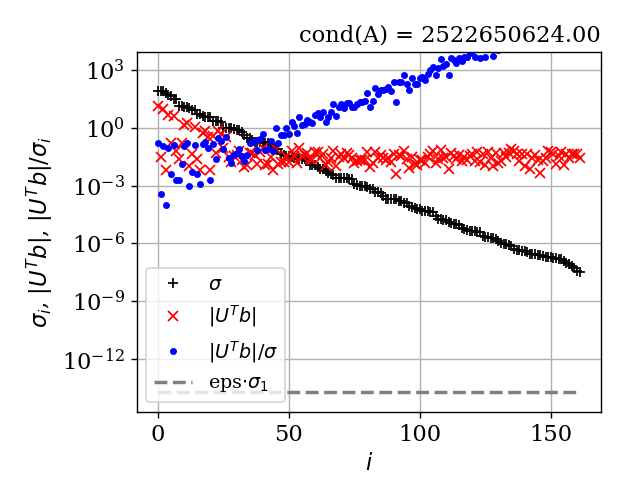

In [14]:
# SVD
[U,s,V] = lc.csvd(H)
print('shape of matrix U: {}'.format(U.shape))
print(r'shape of matrix Sigma: {}'.format(s.shape))
print(r'shape of matrix V^H: {}'.format(V.T.shape))
# plot Picard
lc.plot_picard(U,s,p)

<IPython.core.display.Javascript object>


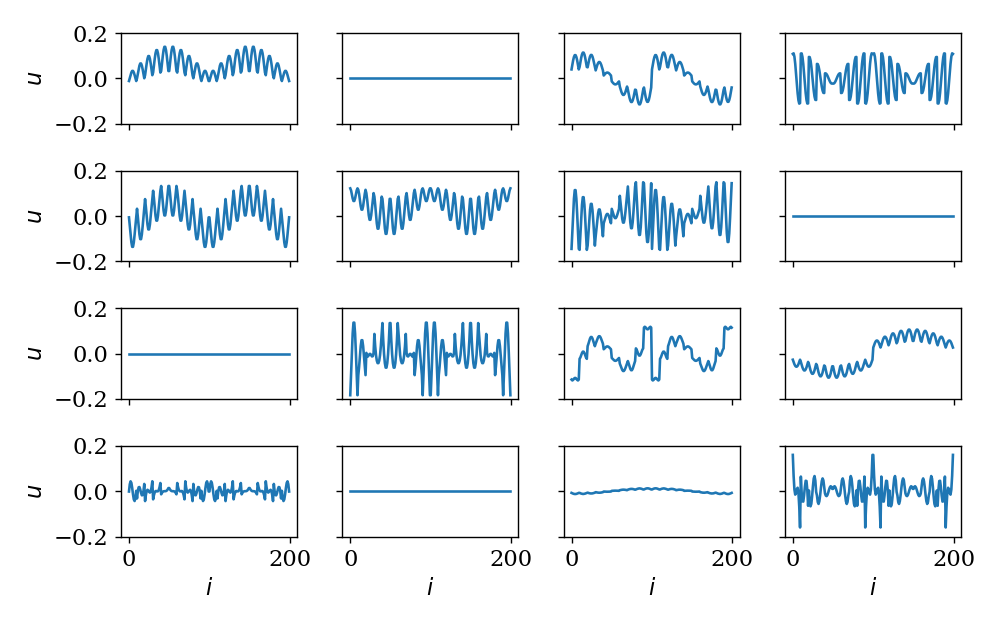

In [15]:
# plot column vectors
lc.plot_colvecs(np.real(U))

# 5. Usar o SVD e o vetor $\textbf{p}$ para computar um parâmetro de regularização, $\lambda$.

# GCV

Compute o parâmetro de regularização por GCV e então a solução de Tikhonov

<IPython.core.display.Javascript object>


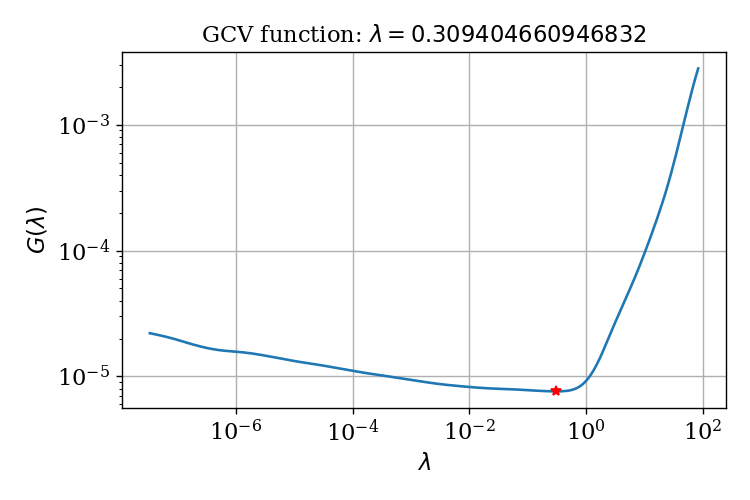

In [16]:
lam_gcv = lc.gcv_lambda(U, s, p, print_gcvfun = True)

# L-curve

Compute o parâmetro de regularização por L-curve e então a solução de Tikhonov

C:\Users\Cliente\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<IPython.core.display.Javascript object>


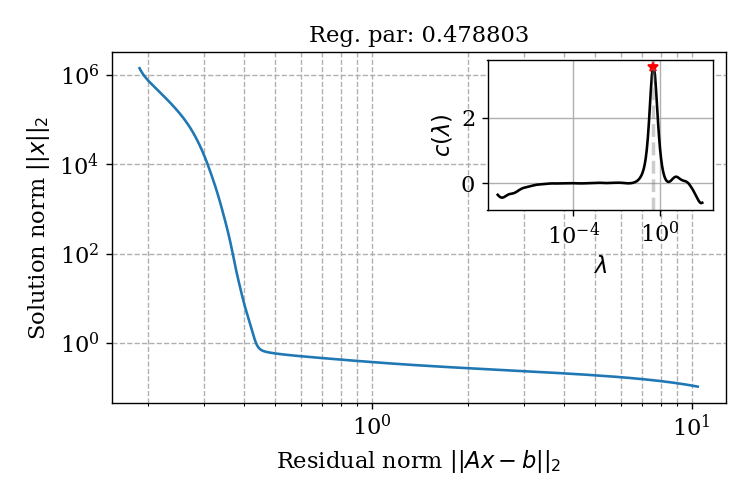

In [17]:
lam_lc = lc.l_curve(U, s, p, plotit = True)

# 6. Computar a solução regularizada (as amplitudes complexas de suas $L$ ondas planas).

In [18]:
x_gcv = lc.tikhonov(U, s, V, p, lam_gcv)
x_lc = lc.tikhonov(U, s, V, p, lam_lc[0])

# 7(a). Análise do resultado

- Vamos escolher a solução pela curva L para um primeiro plot
- Vamos plotar a magnitude (em dB - normalizado) das ondas planas na esfera (de possibilidades). Vamos usar um scatter plot pra isso.

#### Vamos relembrar o cenário medido

<IPython.core.display.Javascript object>


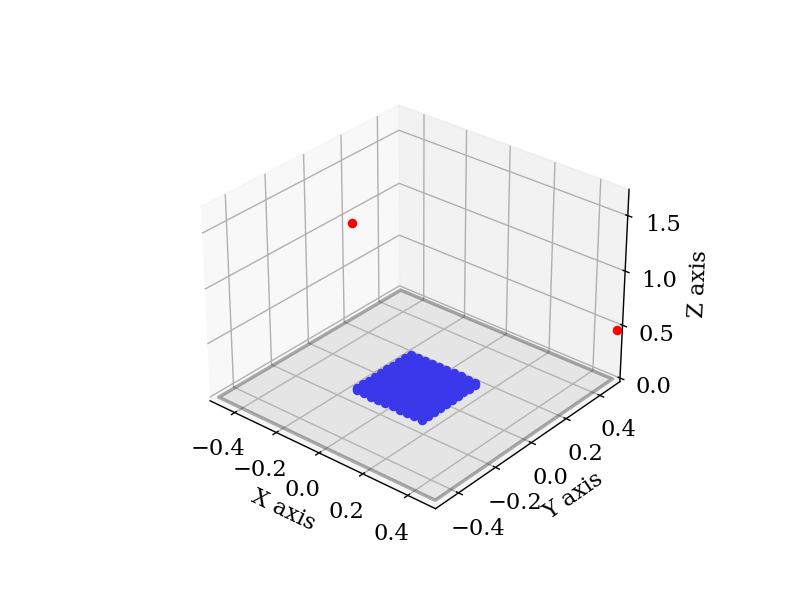

In [19]:
field.plot_scene(vsam_size=1)

<IPython.core.display.Javascript object>


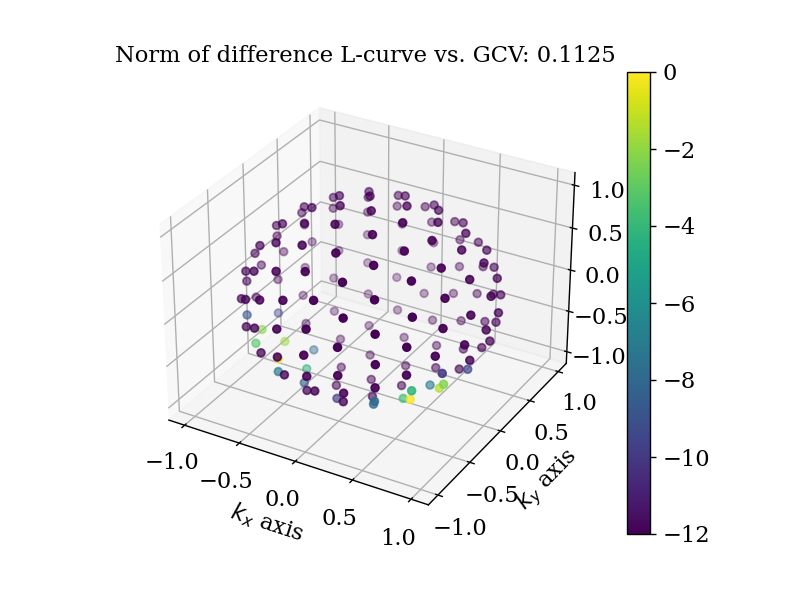

In [20]:
dinrange = 12 # Choose dynamic range for plot.
sol = x_lc # Choose solution
color_par = 20*np.log10(np.abs(sol)/np.amax(np.abs(sol))) # Compute normalized dB value (rel. to max)
# Compute the out of dynamic range data
id_outofrange = np.where(color_par < -dinrange) 
color_par[id_outofrange] = -dinrange

# plot
fig = plt.figure()
ax = plt.axes(projection ="3d")
pp=ax.scatter(dirs[:,0], dirs[:,1], dirs[:,2], c = color_par, vmin = -dinrange, vmax = 0)
fig.colorbar(pp)
ax.set_title('Norm of difference L-curve vs. GCV: {:.4f}'.format(np.linalg.norm(x_lc-x_gcv)))
ax.set_xlabel(r'$k_x$ axis')
ax.set_ylabel(r'$k_y$ axis')
ax.set_zlabel(r'$k_z$ axis');
#plt.tight_layout()


# Going pro

O que quero dizer com isso é que você pode programar tudo de forma organizada e ter escolhas como o tipo de regularização, escolha automática do parâmetro de regularização, plots das informações, reconstrução, etc. Assim, tudo fica organizado e você consegue fazer as coisas com boa repetibilidade. 

A classe **Decomposition** do repositório tem como objetivo a decomposição do campo acústico em ondas planas propagantes.

You choose GCV to find optimal regularization parameter
The number of created waves is: 642


<IPython.core.display.Javascript object>


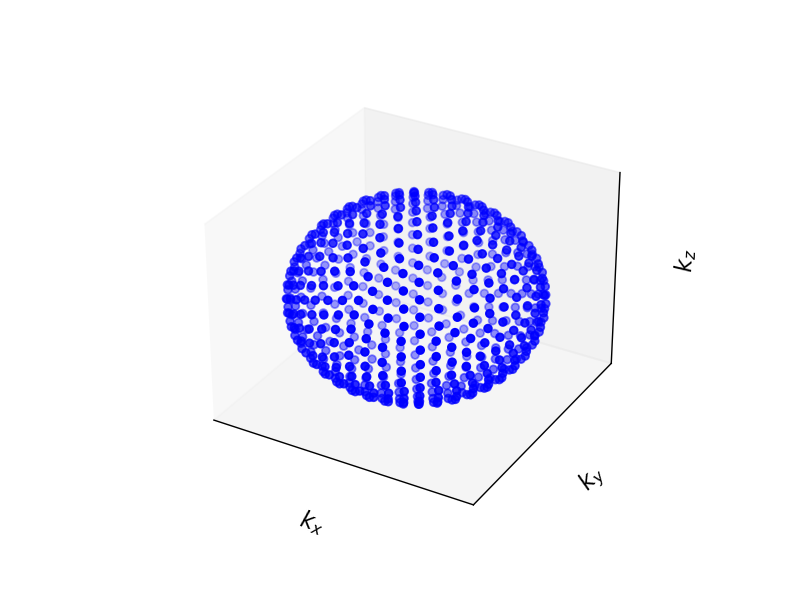

In [21]:
dec_gcv = Decomposition(field.pres_s[0], controls = controls, receivers=receivers, regu_par = 'GCV')
dec_gcv.wavenum_dir(n_waves = 642, plot = True)

Calculating Tikhonov inversion...:   0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


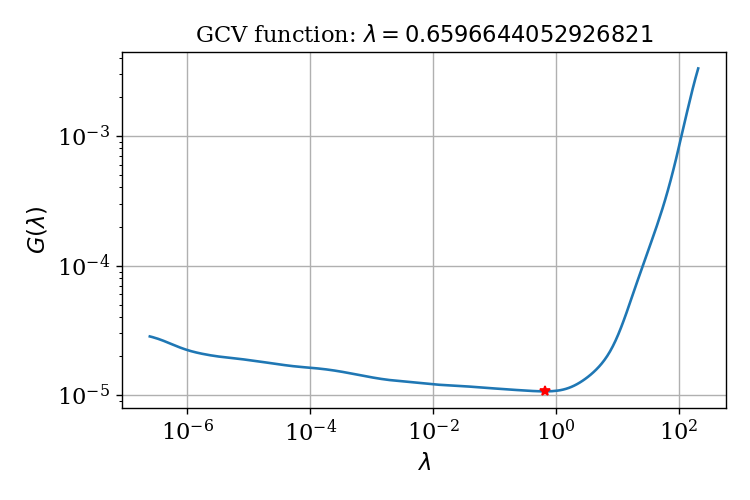

Calculating Tikhonov inversion...:  25%|██▌       | 1/4 [00:00<00:00,  3.63it/s]

<IPython.core.display.Javascript object>


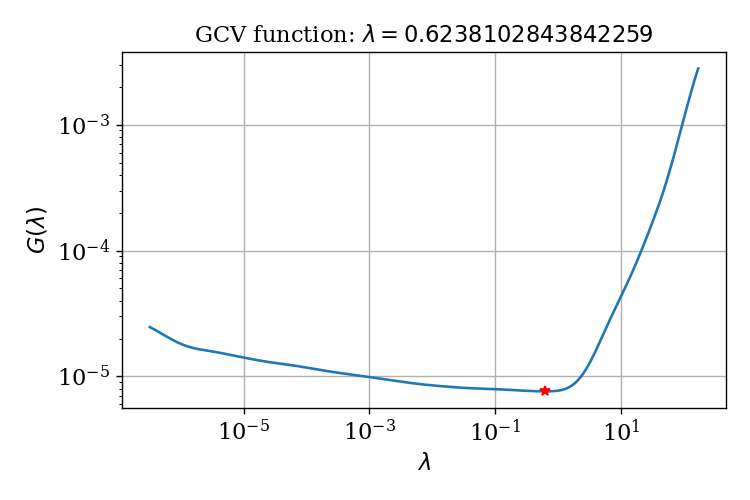

Calculating Tikhonov inversion...:  50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

<IPython.core.display.Javascript object>


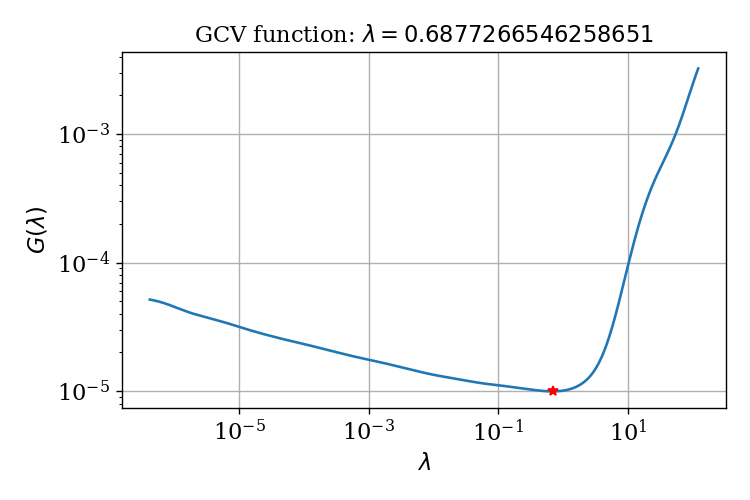

Calculating Tikhonov inversion...:  75%|███████▌  | 3/4 [00:00<00:00,  3.68it/s]

<IPython.core.display.Javascript object>


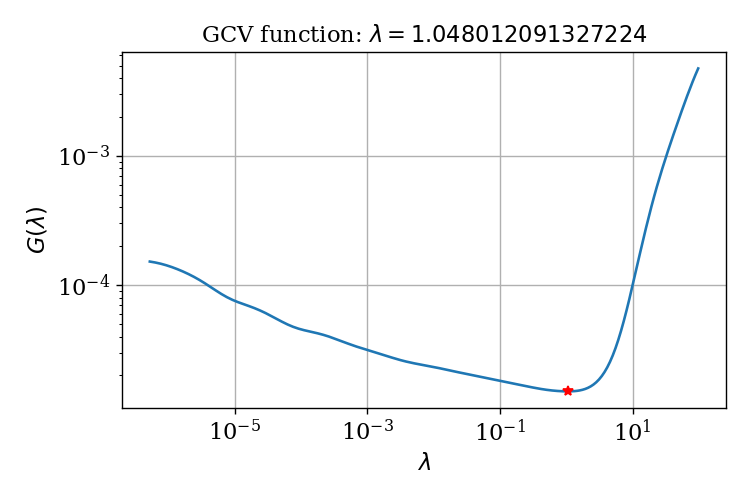

Interpolating the grid for P(k): 100%|██████████| 4/4 [00:00<00:00, 47.18it/s]


In [22]:
dec_gcv.pk_tikhonov(plot_l = True, method = 'Tikhonov')
dec_gcv.pk_interpolate() # Interpolation allows you to plot data on a mundi-map like color map

<IPython.core.display.Javascript object>


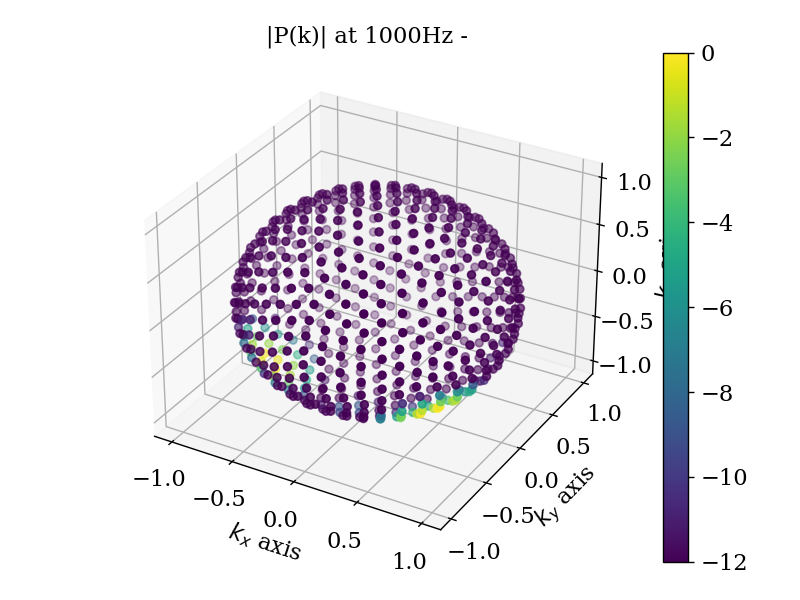

In [23]:
freq_view = 1000
dec_gcv.plot_pk_sphere(freq=freq_view, db=True, dinrange=12, travel=False)

<IPython.core.display.Javascript object>


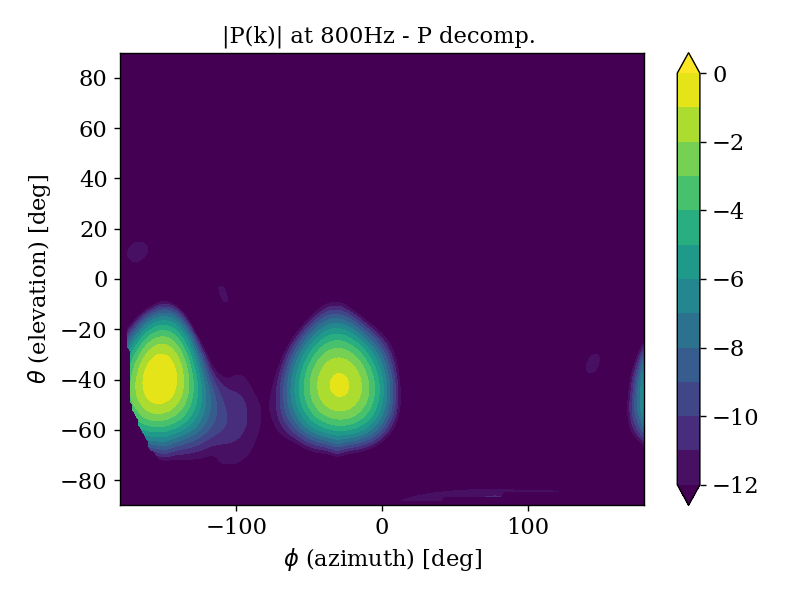

<IPython.core.display.Javascript object>


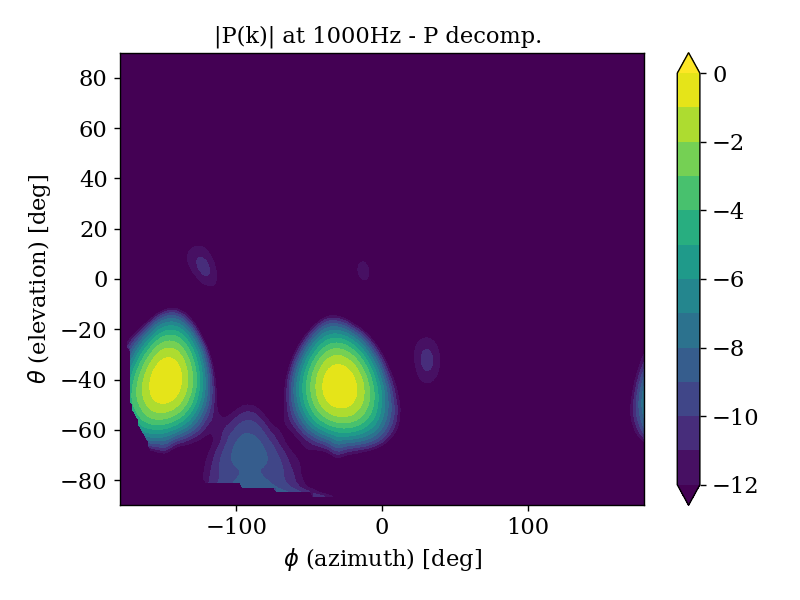

<IPython.core.display.Javascript object>


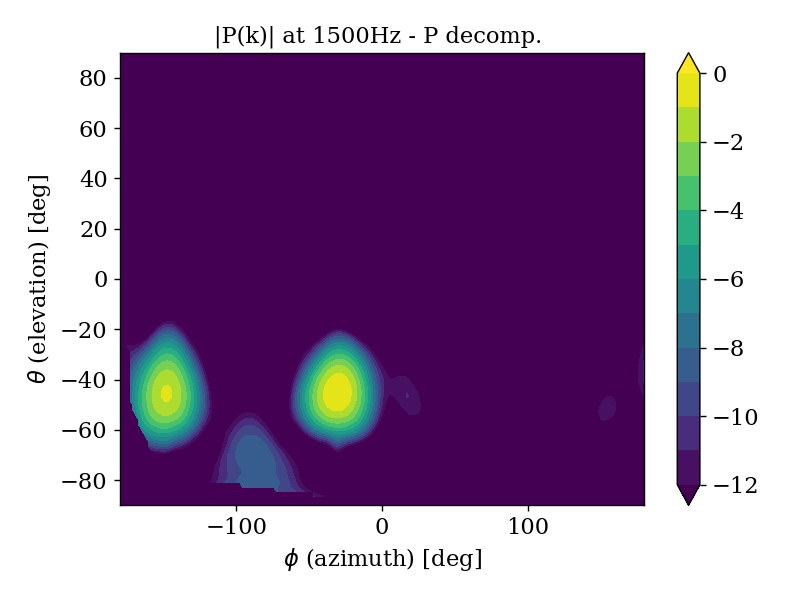

<IPython.core.display.Javascript object>


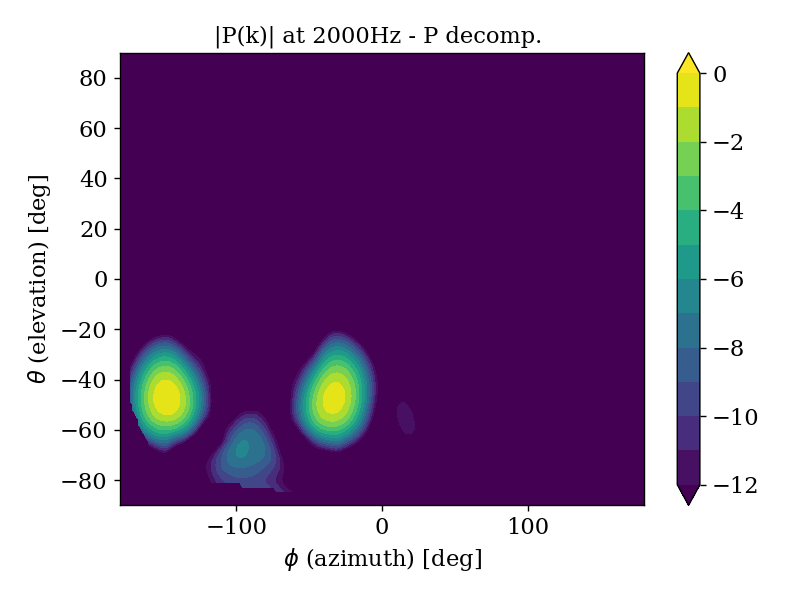

In [24]:
dinrange = 12
dec_gcv.plot_pk_map(freq=800, db=True, dinrange=dinrange)
dec_gcv.plot_pk_map(freq=1000, db=True, dinrange=dinrange)
dec_gcv.plot_pk_map(freq=1500, db=True, dinrange=dinrange)
dec_gcv.plot_pk_map(freq=2000, db=True, dinrange=dinrange)

# 7(b). Reconstrução

D:\Work/dev/insitu_sim_python/insitu\receivers.py:739: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<IPython.core.display.Javascript object>


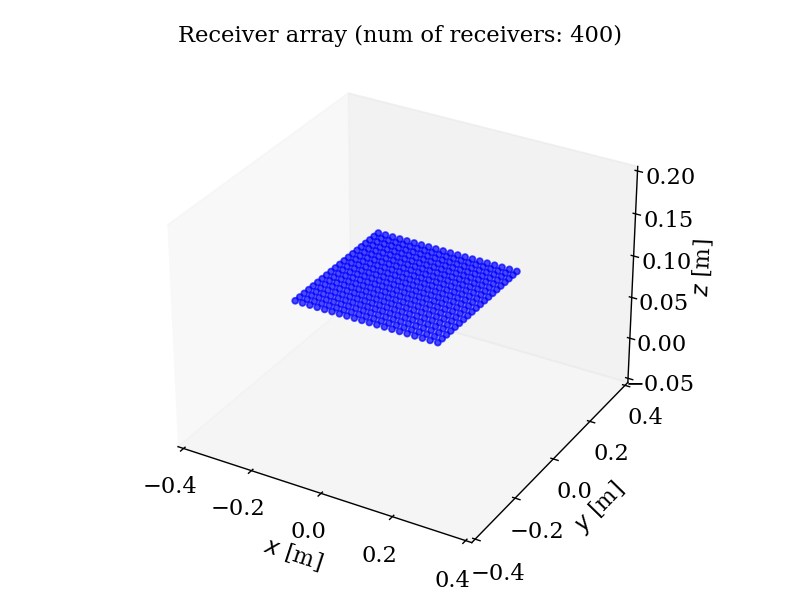

In [25]:
rec_recon = Receiver()
n_x = 20
n_y = 20
rec_recon.planar_array(x_len = 0.4, n_x = n_x, y_len = 0.4, n_y = n_y, zr = 0.1)
rec_recon.plot_array()

## Visualizando o problema novamente

<IPython.core.display.Javascript object>


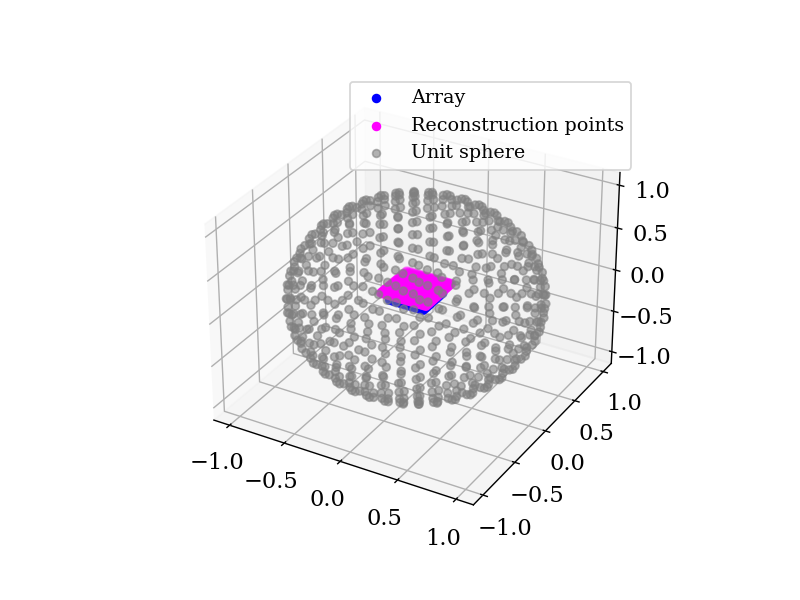

In [26]:
fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter(receivers.coord[:,0], receivers.coord[:,1], receivers.coord[:,2], color='blue', label = 'Array')
ax.scatter(rec_recon.coord[:,0], rec_recon.coord[:,1], rec_recon.coord[:,2], color='magenta', label = 'Reconstruction points')
ax.scatter(dec_gcv.dir[:,0], dec_gcv.dir[:,1], dec_gcv.dir[:,2], color = 'grey', alpha = 0.6, label = 'Unit sphere')
ax.legend()

# Reconstruindo

In [27]:
# Reconstrução
dec_gcv.reconstruct_pu(rec_recon)
print("Shape of reconstructed sound pressure: {}".format(dec_gcv.p_recon.shape))

Reconstructing sound field...: 100%|██████████| 4/4 [00:00<00:00, 23.18it/s]

Shape of reconstructed sound pressure: (400, 4)


# Vamos comparar

Vamos comparar o dado reconstruído com um campo acústico ideal formado pelos mesmos dois monopolos, mas agora computados diretamente no arranjo de reconstrução. 

In [28]:
index = 3 # Choose a frequency
p_reshaped = np.reshape(dec_gcv.p_recon[:,index], (n_x, n_y))

In [29]:
# Referencia
field_recon = FreeField(air, controls, rec_recon)
field_recon.monopole_ff(sources = source)
field_recon.pres_s[0] += field_recon.pres_s[1]
#p_ref_reshaped = np.reshape(field_recon.pres_s[0][:,1]/np.amax(np.abs(field_recon.pres_s[0][:,1])), x_grid.shape)
p_ref_reshaped = np.reshape(field_recon.pres_s[0][:,index], (n_x, n_y))

In [30]:
xcoord_recon = np.linspace(np.amin(rec_recon.coord[:,0]), np.amax(rec_recon.coord[:,0]), n_x)
ycoord_recon = np.linspace(np.amin(rec_recon.coord[:,1]), np.amax(rec_recon.coord[:,1]), n_y)
x_grid, y_grid = np.meshgrid(xcoord_recon, ycoord_recon)

<IPython.core.display.Javascript object>


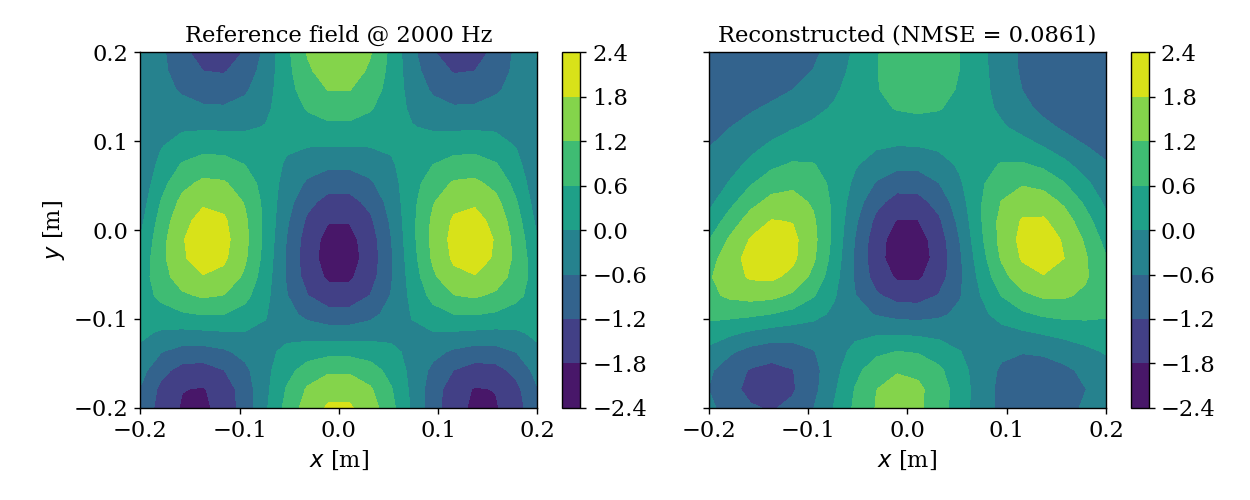

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (10,4), sharey=True)
pp = axs[0].contourf(x_grid, y_grid, np.real(p_ref_reshaped))
axs[0].set_title("Reference field @ {} Hz".format(controls.freq[index]))
fig.colorbar(pp)
axs[0].set_xlabel(r'$x$ [m]')
axs[0].set_ylabel(r'$y$ [m]')

pp = axs[1].contourf(x_grid, y_grid, np.real(p_reshaped))
axs[1].set_title("Reconstructed (NMSE = {:.4f})".format(lc.nmse(dec_gcv.p_recon[:,index], field_recon.pres_s[0][:,index])))
fig.colorbar(pp)
axs[1].set_xlabel(r'$x$ [m]')
#axs[1].set_ylabel(r'$y$ [m]')
plt.tight_layout()


In [32]:
import scipy.io
file_path = 'ang_spk2.mat'
scipy.io.savemat(file_path, {'r_vecs': r_vecs,
                             'dirs': dirs,                            
                            'freq': controls.freq,
                             'k0' : controls.k0,
                            'p': field.pres_s[0],
                            'Upy' : U,
                            'spy' : s,
                            'Vpy' : V,
                            'Hpy' : H})